In [1]:
import os
import json 
import numpy as np
import torch

In [2]:
from birdsong_gan.models.vqvae import VQVAEModel

/home/gagan/anaconda3/envs/birdsonggan/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/gagan/anaconda3/envs/birdsonggan/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
from birdsong_gan.utils.audio_utils import plot_spectrogram

# Load random initialized model

In [4]:
model = VQVAEModel(downsample=True, num_vq_embeddings=128, num_downsample_layers=1, vq_embed_dim=16)

Downsampled latent shape: 64 8


In [5]:
model = model.to("cuda").eval()

# Load model

In [4]:
model_dir = "/home/gagan/ek_experiments/vqvae/2024-02-25_23-00-47/"
model_checkpoint_path = "/home/gagan/ek_experiments/vqvae/2024-02-25_23-00-47/final_model.pt"

In [5]:
model = VQVAEModel.from_pretrained(model_dir, model_checkpoint_path).eval()

Downsampled latent shape: 64 8


# Load dataset

In [6]:
from datasets import load_from_disk

In [52]:
ds = load_from_disk("/home/gagan/ek_processed_data/age_resampled_hfdataset/train/")
len(ds)

488517

# Infer codes

In [53]:
from birdsong_gan.data.data_utils import get_bird_subset, get_age_range_subset, get_all_unique_values, get_random_sample

In [54]:
birds = get_all_unique_values(ds, "bird_name")

In [55]:
birds

['k3r16',
 'b7r16',
 'b13r16',
 'b4g20',
 'b3g20',
 'r15y2',
 'r15y5',
 'p20r16',
 'b6r17',
 'b8r17',
 'g7r15',
 'b14r16',
 'k6r16',
 'g20r15',
 'g19r15_tutor',
 'p3r16',
 'g19r15',
 'r15s12',
 'b8r17_tutor',
 'g20r15_tutor',
 'r15y2_tutor',
 'b4g20_tutor',
 'g7r15_tutor',
 'k3r16_tutor',
 'r15y5_tutor',
 'r15s12_tutor',
 'p3r16_tutor',
 'b7r16_tutor',
 'p20r16_tutor',
 'b13r16_tutor',
 'b6r17_tutor',
 'k6r16_tutor',
 'b3g20_tutor',
 'b14r16_tutor']

In [56]:
subds = get_bird_subset(ds, bird="k3r16")
len(subds)

34673

In [57]:
dph = np.unique(subds["days_post_hatch"])

In [58]:
dph

array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90])

In [59]:
subds_day = get_age_range_subset(subds, dph_lower=45, dph_upper=45)
len(subds_day)

703

In [62]:
import pdb

def preprocess_example(x, device: str = "cuda"):
    x = np.array(x["spectrogram"])
    x = np.log1p(x)
    return torch.from_numpy(x).to(torch.float32).to(device)


def encode_sample(sample):
    x = preprocess_example(sample)
    codes = model.infer_latent_codes_for_spectrogram(x)
    x = model.chunk_spectrogram(x, 16)
    xhat = model.reconstruct(x)
    return codes, xhat, x


def encode_sample2(sample, chunk_length: int = 16):
    
    x = preprocess_example(sample)
    
    codes = model.infer_latent_codes_for_spectrogram(x)
    
    x = model.chunk_spectrogram(x, chunk_length)
    
    xhat = model.decode_spectrogram_from_codes(codes)
    xhat = model.chunk_spectrogram(xhat, chunk_length)
    return codes, xhat, x

In [63]:
c, xhat, x = encode_sample2(subds_day[3])

In [64]:
c.shape

torch.Size([24, 64, 8])

In [65]:
xhat.shape

torch.Size([24, 1, 129, 16])

In [67]:
cflat = c.flatten()
cflat.shape

torch.Size([12288])

# Sampling test

# Plot both

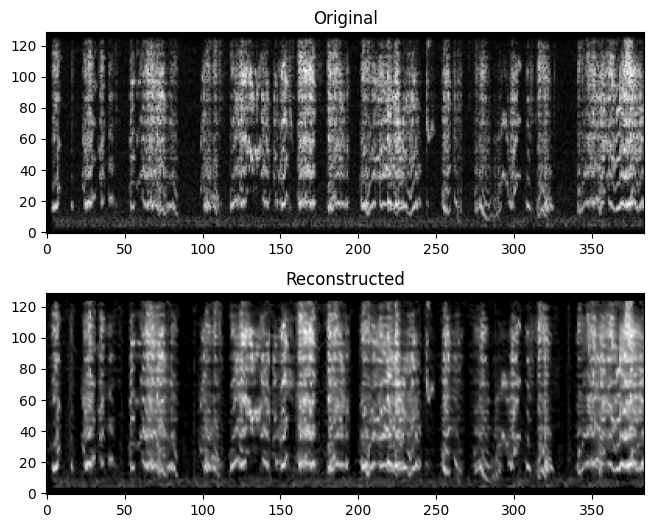

In [66]:
plot_reconstruction_and_original(x, xhat)

In [26]:
import matplotlib.pyplot as plt
from birdsong_gan.utils.audio_utils import rescale_spectrogram

def plot_reconstruction_and_original(
    x: torch.Tensor,
    xhat: torch.Tensor,
    figsize: tuple[int, int] = (20, 6),
) -> None:
    """Plot original and reconstructed spectrograms.

    Input spectrgrams have shape (batch_size, nfreq, ntimeframes).
    Converts them to (nfreq, ntimeframes x batch_size) for plotting.

    :param x: original spectrogram
    :type x: torch.Tensor
    :param xhat: reconstructed spectrogram
    :type xhat: torch.Tensor
    :param epoch: current epoch
    :type epoch: int
    :param batch: current batch
    :type batch: int
    :param experiment_dir: directory to save plots
    :type experiment_dir: str
    :param figsize: figure size, defaults to (12, 8)
    :type figsize: tuple[int, int], optional

    """
    x = x.squeeze()
    x = np.concatenate([xx.cpu().detach().numpy() for xx in x], axis=-1)
    xhat = xhat.squeeze()
    xhat = np.concatenate([xx.cpu().detach().numpy() for xx in xhat], axis=-1)
    x = rescale_spectrogram(x)
    xhat = rescale_spectrogram(xhat)
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    axes[0].imshow(x, origin="lower", cmap="gray")
    axes[0].set_title("Original")
    axes[1].imshow(xhat, origin="lower", cmap="gray")
    axes[1].set_title("Reconstructed")
    # Adjust the space between the subplots
    plt.subplots_adjust(hspace=0.3)  # Adjusts the horizontal space
    plt.show()

In [24]:
c.shape

torch.Size([9, 64, 8])

In [32]:
9*32*4

1152

In [47]:
x = preprocess_example(subds_day[1])
x = model.chunk_spectrogram(x)
x.shape

torch.Size([19, 1, 129, 16])

In [60]:
# create random order
order = np.random.permutation(19)
x2 = x[order]

In [61]:
order

array([ 7,  4,  1,  6, 12,  2, 17, 11, 10, 15,  0,  8,  5, 16,  9, 18,  3,
       13, 14])

In [62]:
x2.shape

torch.Size([19, 1, 129, 16])

In [63]:
xhat, l2, commloss, _, _ = model(x2)

In [64]:
l2

tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)

In [65]:
c.shape

torch.Size([19, 32, 4])

In [66]:
xhat.shape

torch.Size([19, 1, 129, 16])

In [67]:
xhat = model.unchunk_spectrogram(xhat).detach()
x2 = model.unchunk_spectrogram(x2).detach()

# Test sampling

In [32]:
codes = model.sample_uniform_random_codes((32, 64, 8))

In [33]:
codes.shape

torch.Size([32, 64, 8])

In [40]:
latents = model.vq.quantize.embedding(codes)
latents.shape

torch.Size([32, 64, 8, 1])

In [39]:
xhat = model.decode(latents)

In [6]:
x = torch.rand(32, 1, 129, 16).to("cuda")
x.shape

torch.Size([32, 1, 129, 16])

In [7]:
codes = model.infer_latent_code(x)

In [8]:
codes.shape

torch.Size([16384])

In [9]:
codes

tensor([ 81,  81,  73,  ...,  12, 116,   8], device='cuda:0')

In [10]:
model.vq.quantize.sane_index_shape = True

In [12]:
codes = model.infer_latent_code(x)
codes.shape

torch.Size([32, 64, 8])